In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [2]:
P0 = lambda n, theta: np.cos((2*n+1)*theta)**2
P1 = lambda n, theta: np.sin((2*n+1)*theta)**2

def estimate_signal(depths, n_samples, theta, eta=0.0):
        signals = np.zeros(len(depths), dtype = np.complex128)
        cos_signal = np.zeros(len(depths), dtype = np.complex128)
        for i,n in enumerate(depths):
            # Get the exact measuremnt probabilities
            p0 = P0(n, theta)
            p1 = P1(n, theta)

            p0x = P0x(n,theta)
            p1x = P1x(n,theta)

            # Get the "noisy" probabilities by sampling and adding a bias term that pushes towards 50/50 mixture
            eta_n = (1.0-eta)**(n+1) # The error at depth n increases as more queries are implemented
            p0_estimate = np.random.binomial(n_samples[i], eta_n*p0 + (1.0-eta_n)*0.5)/n_samples[i]
            p1_estimate = 1 - p0_estimate
            # p1_estimate = np.random.binomial(n_samples[i], eta_n*p1 + (1.0-eta_n)*0.5)/n_samples[i]
            p0x_estimate = np.random.binomial(n_samples[i], eta_n*p0x + (1.0-eta_n)*0.5)/n_samples[i]
            p1x_estimate = 1.0 - p0x_estimate
            
            # Estimate theta
            theta_estimated = np.arctan2(p0x_estimate - p1x_estimate, p0_estimate - p1_estimate)

            # estimate cos(2n+1)2theta
            # cos_signal[i] = p0_estimate - p1_estimate
            
            # Store this to determine angle at theta = 0 or pi/2
            if i==0:
                p0mp1 = p0_estimate - p1_estimate

            # Compute f(n) - Eq. 3
            fi_estimate = np.exp(1.0j*theta_estimated)
            # fi_estimate = 2*p0_estimate - 1 + 1.0j*np.sqrt(1-(2*p0_estimate - 1)**2)
            # fi_estimate = 2*p0_estimate - 1
            # fi_estimate = np.cos((2*n+1)*2*theta)
            # fi_estimate = np.exp(1.0j*(2*n+1)*2*theta)
            # fi_estimate = 2*p0 - 1 + np.random.normal(0.0, 1/n_samples[i])

            # signals[i] = np.real(fi_estimate)
            signals[i] = fi_estimate
         
        return signals    

## Test eigenvalues of R

In [3]:
a = 0.3
theta = np.arcsin(a)
w = 2*theta

q=4

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=10)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal) #don't know
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

random_signs = np.random.choice([-1, 1], size=len(signs))

print(signs)
#corrupt the signs
# signs[1:] = -1 * signs[1:]
# signs[1] = -1 * signs[1]
# signs[2] = -1 * signs[2]
print(random_signs)

csignal = cos_signal + 1.0j * random_signs * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)
theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)


fft1 = np.abs(np.fft.fft(R1/len(R1)))
fft2 = np.abs(np.fft.fft(R2/len(R2)))

print(f"max fourier coefficient: {(np.max(fft1), np.max(fft2))}")
print(f"l4 norm fourier coefficients: {(np.linalg.norm(fft1, 4), np.linalg.norm(fft2, 4))}")
# print(np.max(fft1), np.max(fft2))

# xaxis = [i*np.pi/(2*len(fft1)) for i in range(len(fft1))]
# plt.figure()
# plt.plot(xaxis, fft1)

# plt.figure()
# plt.plot(xaxis, fft2)
print(theta_est1, theta_est2)



depths:[  0   1   2   4   8  16  32  64 128]
[ 1.  1.  1. -1. -1.  1.  1.  1. -1.]
[ 1  1  1  1 -1 -1 -1  1  1]
max fourier coefficient: (0.39105247022004225, 0.9588636516800879)
l4 norm fourier coefficients: (0.44841951696708837, 0.9591840724160644)
0.4784906823678828 0.30460109451868156


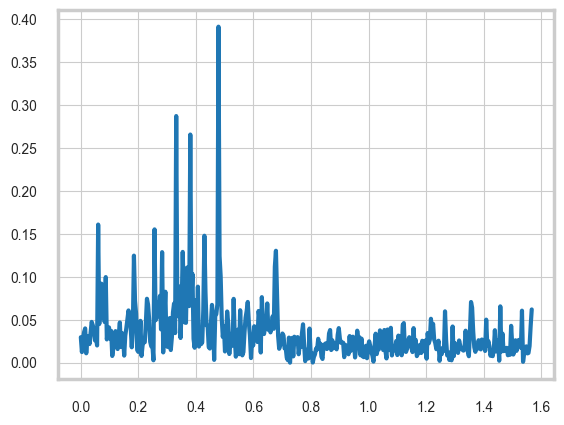

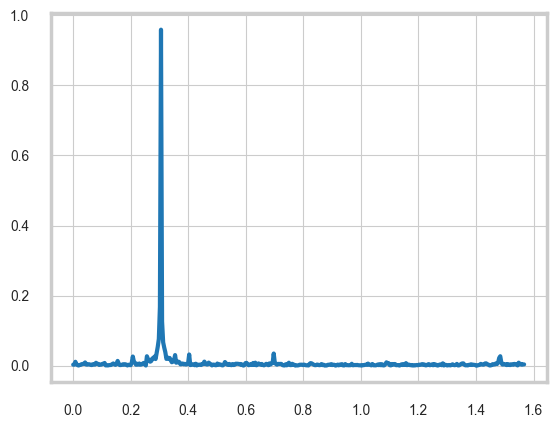

In [4]:
xaxis = [i*np.pi/(2*len(fft1)) for i in range(len(fft1))]
plt.figure()
plt.plot(xaxis, fft1)

plt.figure()
plt.plot(xaxis, fft2)

In [9]:
a = 0.3
theta = np.arcsin(a)
w = 2*theta

q=6

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=3)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal)
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

plusminus = [1, -1]

s = np.ones(len(signal)) #optimized signs

for i in range(1, len(signal)):
    obj = np.zeros(2)
    ula = TwoqULASignal(M=narray[:i])
    # print(ula.depths)
    for j, sign in enumerate(plusminus):
        s[i] = sign
        csignal = cos_signal[:i+1] + 1.0j * s[:i+1] * abs_sin[:i+1]
        
        R = ula.get_cov_matrix_toeplitz(csignal)
        theta_est, _ = espirit.estimate_theta_toeplitz(R)

        # print(len(R))
        fft = np.abs(np.fft.fft(R)/len(R))
        # print(fft)
        # obj[j] = np.linalg.norm(fft, 4)
        # obj[j] = np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])
        obj[j] = np.abs(espirit.eigs[0])

        # obj[j] = np.max(fft)
    # print(R)
    signal2 = signal[:i+1]
    R_true = ula.get_cov_matrix_toeplitz(signal2)

    _, _ = espirit.estimate_theta_toeplitz(R_true)
    # print(f"true: {np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])}")
    print(f"true: {np.abs(espirit.eigs[0])}")

    fft_true = np.abs(np.fft.fft(R_true)/len(R_true))
    # print(fft)
    # print(np.linalg.norm(fft_true, 4))

    print(f"+1 -1: {obj}")
    idx = np.argmax(obj)
    s[i] = plusminus[idx]
        
# np.dot(signs, s)/len(s)

csignal = cos_signal + 1.0j * s * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
eigs1 = espirit.eigs

R2 = ula_signal.get_cov_matrix_toeplitz(signal)
eigs2 = espirit.eigs

theta_est1, _ = espirit.estimate_theta_toeplitz(R1)

theta_est2, _ = espirit.estimate_theta_toeplitz(R2)

print(signs, s)

(theta_est1, np.abs(eigs1[0])), (theta_est2, np.abs(eigs2[0])), theta

    

depths:[   0    1    2    4    8   16   32   64  128  256  512 1024 2048]
true: 0.37115904971950175
+1 -1: [0.53026172 0.34825564]
true: 2.884434159354319
+1 -1: [2.93345966 2.98923741]
true: 8.893347131994997
+1 -1: [8.81654861 8.84949028]
true: 16.586391202801014
+1 -1: [11.32598573 16.31747402]
true: 47.69227406639524
+1 -1: [46.83532724 26.86252274]
true: 78.49196615921187
+1 -1: [77.45842848 56.09714964]
true: 217.04841374869932
+1 -1: [212.49518613 212.49518613]
true: 401.92879416304913
+1 -1: [361.842261  393.2612989]
true: 1037.2244795901584
+1 -1: [ 637.01836891 1008.97749091]
true: 1964.161422174744
+1 -1: [1923.19396577 1933.62068225]
true: 4856.429562664771
+1 -1: [4476.48566003 4286.42949484]
true: 8987.180637729436
+1 -1: [8856.96136597 5115.87864763]
[ 1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1.  1.] [ 1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.]


((0.30543412077030235, 8987.180637729436),
 (0.3046708404157459, 8987.180637729436),
 0.30469265401539747)

In [8]:
(theta_est1, np.abs(eigs1[0])), (theta_est2, np.abs(eigs2[0])), theta

((0.3047457562817879, 7769.397630630968),
 (0.3048237179854983, 7769.397630630968),
 0.30469265401539747)

In [10]:
a = 0.4
theta = np.arcsin(a)
w = 2*theta

q=6

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=3)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal)
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

plusminus = [1, -1]

s = np.ones(len(signal))

for i in range(len(signal)//2):
    obj = {}
    ula = TwoqULASignal(M=narray[:2*i+1])
    # print(len(ula.depths), 2*i+2)
    # print(ula.depths)
    for j, sign1 in enumerate(plusminus):
        for k, sign2 in enumerate(plusminus):
            s[2*i] = sign1
            s[2*i+1] = sign2
            csignal = cos_signal[:2*i+2] + 1.0j * s[:2*i+2] * abs_sin[:2*i+2]
            # print(csignal)
            R = ula.get_cov_matrix_toeplitz(csignal)
            # print(R)
            theta_est, _ = espirit.estimate_theta_toeplitz(R)

            # print(len(R))
            # fft = np.abs(np.fft.fft(R)/len(R))
            # print(fft)
            # obj[j] = np.linalg.norm(fft, 4)
            # obj[j] = np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])
            obj[(sign1, sign2)] = np.abs(espirit.eigs[0])

        # obj[j] = np.max(fft)
    # print(R)
    signal2 = signal[:2*i+2]
    R_true = ula.get_cov_matrix_toeplitz(signal2)

    _, _ = espirit.estimate_theta_toeplitz(R_true)
    # print(f"true: {np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])}")
    print(f"true: {np.abs(espirit.eigs[0])}")

    # fft_true = np.abs(np.fft.fft(R_true)/len(R_true))
    # print(fft)
    # print(np.linalg.norm(fft_true, 4))

    print(f"+1 -1: {obj}")
    two_signs = max(obj, key=obj.get)
    s[2*i - 1] = two_signs[0]
    s[2*i] = two_signs[1]
        
# np.dot(signs, s)/len(s)

csignal = cos_signal + 1.0j * s * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)

theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)

print(signs, s)

theta_est1, theta_est2, theta


depths:[   0    1    2    4    8   16   32   64  128  256  512 1024 2048]
true: 1.3084334050526196
+1 -1: {(1, 1): 1.3539087764992197, (1, -1): 0.5311731306996135, (-1, 1): 0.2883803876637304, (-1, -1): 0.310136856295762}
true: 8.937451437702858
+1 -1: {(1, 1): 7.879334243846952, (1, -1): 6.231184927446758, (-1, 1): 6.641252012615125, (-1, -1): 6.313479778899697}
true: 48.48223318652374
+1 -1: {(1, 1): 37.25207077834509, (1, -1): 31.209137084825002, (-1, 1): 27.956207857692842, (-1, -1): 22.03746167061373}
true: 219.00985898285936
+1 -1: {(1, 1): 50.95356391978959, (1, -1): 63.24878842550684, (-1, 1): 65.81845232493453, (-1, -1): 63.69438787635853}
true: 1057.0872968652639
+1 -1: {(1, 1): 158.47773172379777, (1, -1): 234.15810360319827, (-1, 1): 295.1920136510108, (-1, -1): 256.8236588203358}
true: 4858.998052789902
+1 -1: {(1, 1): 1195.9163011369724, (1, -1): 1195.9163011369722, (-1, 1): 997.3280111568646, (-1, -1): 997.3280111568641}
[ 1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -

(1.534153498783515, 0.41145805313672423, 0.41151684606748806)

## Implement the above cell in a function

In [79]:
import numpy as np
n=3

def all_sign_combinations(n):
    def generate_combinations(current, remaining):
        if remaining == 0:
            yield current
        else:
            yield from generate_combinations(current + [1.0], remaining - 1)
            yield from generate_combinations(current + [-1.0], remaining - 1)

    return list(generate_combinations([], n))

all_signs = all_sign_combinations(len(depths))

print(f"All possible sign combinations for {n} elements:")
print(all_signs)
print(f"\nTotal number of combinations: {len(all_signs)}")

All possible sign combinations for 3 elements:
[[1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, -1.0], [1.0, 1.0, 1.0, -1.0, 1.0], [1.0, 1.0, 1.0, -1.0, -1.0], [1.0, 1.0, -1.0, 1.0, 1.0], [1.0, 1.0, -1.0, 1.0, -1.0], [1.0, 1.0, -1.0, -1.0, 1.0], [1.0, 1.0, -1.0, -1.0, -1.0], [1.0, -1.0, 1.0, 1.0, 1.0], [1.0, -1.0, 1.0, 1.0, -1.0], [1.0, -1.0, 1.0, -1.0, 1.0], [1.0, -1.0, 1.0, -1.0, -1.0], [1.0, -1.0, -1.0, 1.0, 1.0], [1.0, -1.0, -1.0, 1.0, -1.0], [1.0, -1.0, -1.0, -1.0, 1.0], [1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, 1.0, 1.0, 1.0, 1.0], [-1.0, 1.0, 1.0, 1.0, -1.0], [-1.0, 1.0, 1.0, -1.0, 1.0], [-1.0, 1.0, 1.0, -1.0, -1.0], [-1.0, 1.0, -1.0, 1.0, 1.0], [-1.0, 1.0, -1.0, 1.0, -1.0], [-1.0, 1.0, -1.0, -1.0, 1.0], [-1.0, 1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, 1.0, 1.0, 1.0], [-1.0, -1.0, 1.0, 1.0, -1.0], [-1.0, -1.0, 1.0, -1.0, 1.0], [-1.0, -1.0, 1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, 1.0, 1.0], [-1.0, -1.0, -1.0, 1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, 1.0], [-1.0, -1.0, -1.0, -1.0, -1.0]]

Total n

In [178]:
def estimate_amplitude(theta, narray, ula_signals, verbose=False):

    ula_signal = ula_signals[0]
    espirit = ESPIRIT()

    depths = ula_signal.depths
    n_samples = ula_signal.n_samples

    signal = estimate_signal(depths, n_samples, theta)
    cos_signal = np.real(signal)
    signs = np.sign(np.imag(signal))
    abs_sin = np.abs(np.imag(signal))

    plusminus = [1, -1]

    s = np.ones(len(signal))

    for i in range(1, len(signal)):
        obj = np.zeros(2)
        ula = ula_signals[i]
        for j, sign in enumerate(plusminus):
            s[i] = sign
            csignal = cos_signal[:i+1] + 1.0j * s[:i+1] * abs_sin[:i+1]
            
            R = ula.get_cov_matrix_toeplitz(csignal)
            _, _ = espirit.estimate_theta_toeplitz(R)
            # fft = np.abs(np.fft.fft(R)/len(R))
            # print(fft)
            # obj[j] = np.linalg.norm(fft, 4)
            # obj[j] = np.max(fft)
            eigs = np.abs(espirit.eigs)[:2]
            obj[j] = np.linalg.norm(eigs, 8)
        # signal2 = signal[:i+1]
        # R_true = ula.get_cov_matrix_toeplitz(signal2)

        # _, _ = espirit.estimate_theta_toeplitz(R_true)
        # # print(f"true: {np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])}")
        # print(f"true: {np.abs(espirit.eigs[0])}")

        # fft_true = np.abs(np.fft.fft(R_true)/len(R_true))
        # # print(fft)
        # # print(np.linalg.norm(fft_true, 4))
        if verbose:
            print(f"+1 -1: {obj}")
        idx = np.argmax(obj)
        s[i] = plusminus[idx]
            
    # np.dot(signs, s)/len(s)

    csignal = cos_signal + 1.0j * s * abs_sin

    R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
    R2 = ula_signal.get_cov_matrix_toeplitz(signal) #covariance matrix from the complex signal with correct signs

    theta_est1, _ = espirit.estimate_theta_toeplitz(R1)
    eigs1 = espirit.eigs

    theta_est2, _ = espirit.estimate_theta_toeplitz(R2)
    eigs2 = espirit.eigs

    # print(np.abs(eigs1[0]), np.abs(eigs2[0]))


    return theta_est1, theta_est2, np.dot(signs, s)/len(s)

def estimate_amplitude_brute_force(theta, ula_signal, possible_signs, verbose=False):

    espirit = ESPIRIT()

    depths = ula_signal.depths
    n_samples = ula_signal.n_samples

    signal = estimate_signal(depths, n_samples, theta)
    cos_signal = np.real(signal)
    true_signs = np.sign(np.imag(signal))
    print(true_signs)
    abs_sin = np.abs(np.imag(signal))

    obj = 0
    all_signs = possible_signs
    for signs in all_signs:
        signs = np.array(signs)
        csignal = cos_signal + 1.0j * signs * abs_sin
        
        R = ula_signal.get_cov_matrix_toeplitz(csignal)
        _, _ = espirit.estimate_theta_toeplitz(R)
        eigs = np.abs(espirit.eigs)[:2]
        # curr_obj = np.abs(eigs[0]) - np.abs(espirit.eigs[1])
        # curr_obj = np.linalg.norm(eigs, 1)
        fft = np.abs(np.fft.fft(R)/len(R))
        curr_obj = np.linalg.norm(fft, 4)
        # curr_obj = np.max(fft)
        if curr_obj>obj:
            s = signs
            obj = curr_obj
        if verbose:
            print(f"+1 -1: {obj}")
            
    print(s)
    csignal = cos_signal + 1.0j * s * abs_sin
    signal = cos_signal + 1.0j * true_signs * abs_sin
    R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
    R2 = ula_signal.get_cov_matrix_toeplitz(signal) #covariance matrix from the complex signal with correct signs

    theta_est1, _ = espirit.estimate_theta_toeplitz(R1)
    eigs1 = espirit.eigs

    theta_est2, _ = espirit.estimate_theta_toeplitz(R2)
    eigs2 = espirit.eigs

    print(np.abs(eigs1[0]) - np.abs(eigs1[1]), np.abs(eigs2[0]) - np.abs(eigs2[1]))


    return theta_est1, theta_est2, np.dot(true_signs, s)/len(s)

In [164]:
a = 0.5
theta = np.arcsin(a)
# theta = 0.7*np.pi/4
w = 2*theta

q=3

narray = [2]*(2*q+2)
# narray = [3,3,2,2,2]
ula_signal = TwoqULASignal(M=narray, C=6)
depths = ula_signal.depths

ula_signals = [ula_signal]
for i in range(1, len(depths)):
    ula = TwoqULASignal(M=narray[:i])
    ula_signals.append(ula)

num_mc=100
thetas1 = np.zeros(num_mc)
thetas2 = np.zeros(num_mc)
errors1 = np.zeros(num_mc)
errors2 = np.zeros(num_mc)
sign_overlap = np.zeros(num_mc)
for i in range(num_mc):
    theta_est1, theta_est2, overlap = estimate_amplitude(theta, narray, ula_signals)
    error1 = np.abs(np.sin(theta)-np.sin(theta_est1)) 
    error2 = np.abs(np.sin(theta)-np.sin(theta_est2))
    thetas1[i] = theta_est1    
    thetas2[i] = theta_est2       
    errors1[i] = error1
    errors2[i] = error2
    sign_overlap[i] = overlap

num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
# Compute the maximum single query
max_single_query = np.max(ula_signal.depths)

print(f'Number of queries: {num_queries}')
print(f'Ave theta estimated: {np.mean(thetas1)}')
print(f'a = {np.sin(theta)}; a_est = {np.sin(np.mean(thetas1))}')

print(f'95% percentile: {np.percentile(errors1, 95):e}')
print(f'80% percentile: {np.percentile(errors1, 80):e}')
print(f'68% percentile: {np.percentile(errors1, 68):e}')
print(f'average sign overlap: {np.mean(sign_overlap)}')
print()

Number of queries: 6078
Ave theta estimated: 0.5247618499501794
a = 0.49999999999999994; a_est = 0.5010069135226778
95% percentile: 1.140815e-03
80% percentile: 8.317342e-04
68% percentile: 6.321529e-04
average sign overlap: 0.5577777777777778



In [165]:
np.percentile(errors1, 95)*num_queries, np.percentile(errors1, 95)*max_single_query

(6.933875121263841, 0.1460243526689325)

In [14]:
thetas2/thetas1

array([0.49679814, 0.49683154, 0.49680308, 0.49680945, 0.49680459])

In [74]:
errors1, errors2

(array([0.02365912, 0.00086046, 0.00079764, 0.00134458, 0.00010956]),
 array([4.96119908e-04, 8.60457931e-04, 7.97636050e-04, 8.79595142e-05,
        1.09557512e-04]))

In [137]:
print(f'95% percentile: {np.percentile(errors2, 95):e}')
print(f'80% percentile: {np.percentile(errors2, 80):e}')
print(f'68% percentile: {np.percentile(errors2, 68):e}')

95% percentile: 1.172864e-03
80% percentile: 7.053327e-04
68% percentile: 5.279753e-04


In [82]:
a = 0.7
theta = np.arcsin(a)
theta, theta/np.pi, np.pi/4

(0.775397496610753, 0.246816688893365, 0.7853981633974483)

In [185]:
a = 0.2
theta = np.arcsin(a)
# theta = 0.7*np.pi/4
w = 2*theta

q=2

narray = [2]*(2*q+2)
# narray = [3,3,2,2,2]
ula_signal = TwoqULASignal(M=narray, C=100)
depths = ula_signal.depths
possible_signs = all_sign_combinations(len(depths))

num_mc=5
thetas1 = np.zeros(num_mc)
thetas2 = np.zeros(num_mc)
errors1 = np.zeros(num_mc)
errors2 = np.zeros(num_mc)
sign_overlap = np.zeros(num_mc)
for i in range(num_mc):
    theta_est1, theta_est2, overlap = estimate_amplitude_brute_force(theta, ula_signal, possible_signs)
    error1 = np.abs(np.sin(theta)-np.sin(theta_est1)) 
    error2 = np.abs(np.sin(theta)-np.sin(theta_est2))
    thetas1[i] = theta_est1    
    thetas2[i] = theta_est2       
    errors1[i] = error1
    errors2[i] = error2
    sign_overlap[i] = overlap

num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
# Compute the maximum single query
max_single_query = np.max(ula_signal.depths)

print(f'Number of queries: {num_queries}')
print(f'Ave theta estimated: {np.mean(thetas1)}')
print(f'a = {np.sin(theta)}; a_est = {np.sin(np.mean(thetas1))}')

print(f'95% percentile: {np.percentile(errors1, 95):e}')
print(f'80% percentile: {np.percentile(errors1, 80):e}')
print(f'68% percentile: {np.percentile(errors1, 68):e}')
print(f'average sign overlap: {np.mean(sign_overlap)}')
print()

[ 1.  1.  1. -1.  1.  1.  1.]
[ 1.  1.  1. -1.  1.  1.  1.]
79.84588946019578 79.84588946019582
[ 1.  1.  1. -1.  1.  1.  1.]
[ 1. -1.  1. -1.  1.  1.  1.]
47.554976720016 79.83192656865482
[ 1.  1.  1. -1.  1.  1.  1.]
[-1.  1. -1.  1. -1. -1. -1.]
44.637444493003954 77.80678440932388
[ 1.  1.  1. -1.  1.  1.  1.]
[-1.  1. -1.  1. -1. -1. -1.]
40.210875835385856 79.10585647338193
[ 1.  1.  1. -1.  1.  1.  1.]
[ 1.  1.  1. -1.  1.  1.  1.]
77.94067607406771 77.94067607406772
Number of queries: 24700
Ave theta estimated: 0.5112332531734927
a = 0.2; a_est = 0.489253190306171
95% percentile: 5.774942e-01
80% percentile: 4.081425e-01
68% percentile: 3.516766e-01
average sign overlap: 0.2571428571428571



In [182]:
print(f'95% percentile: {np.percentile(errors2, 95):e}')
print(f'80% percentile: {np.percentile(errors2, 80):e}')
print(f'68% percentile: {np.percentile(errors2, 68):e}')

95% percentile: 8.445710e-04
80% percentile: 8.386524e-04
68% percentile: 7.535417e-04


In [60]:
len(possible_signs), 2**(len(depths))

(32, 32)

In [77]:
def all_sign_combinations_float(n):
    def generate_combinations(current, remaining):
        if remaining == 0:
            yield current
        else:
            yield from generate_combinations(current + [1.0], remaining - 1)
            yield from generate_combinations(current + [-1.0], remaining - 1)

    return list(generate_combinations([], n))

possible_signs = all_sign_combinations(len(depths))


In [78]:
len(possible_signs)

32

In [75]:
for signs in possible_signs:
    overlap = np.dot([ 1.,  1., -1.,  1.,  1.], signs)/len(signs)
    if overlap > 0.7:
        print(overlap)

## Brute force try all signs

In [6]:
a = 0.3
theta = np.arcsin(a)
w = 2*theta

q=4

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=5)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal)
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

import itertools

def generate_sign_combinations(n):
    signs = [-1, 1]
    combinations = [np.array(combo) for combo in itertools.product(signs, repeat=n)]
    return combinations

# Example usage:
n = len(signal)

combinations = generate_sign_combinations(n)
obj = np.zeros(len(combinations))

for i, combo in enumerate(combinations):
    s = combo
    csignal = cos_signal + 1.0j * s * abs_sin
    R = ula.get_cov_matrix_toeplitz(csignal)
    # print(len(R))
    fft = np.abs(np.fft.fft(R)/len(R))
    # print(fft)
    norm = np.linalg.norm(fft, 4)
    obj[j] = norm
    print(norm)
    # obj[j] = np.max(fft)
        
# np.dot(signs, s)/len(s)
idx = np.argmax(obj)
s = combinations[idx]

csignal = cos_signal + 1.0j * s * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)

theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)

print(signs, s)

theta_est1, theta_est2, theta

    

depths:[  0   1   2   4   8  16  32  64 128]
nan
0.0
0.0
0.0
0.0
0.0
0.12068062199407506
0.1252767008851752
0.11917345302969895
0.12118750798879446
0.12261857320073623
nan
0.0
nan
0.0
0.0
0.0
0.0
0.12259415792360327
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.12061027681666485
0.12135298604615558
0.11756497107379389
0.11766168193284371
0.0
0.115275180471296
0.12011294011122656
0.11539850932748001
0.11819681334036553
0.12509063308481688
0.1264825215485083
0.11797058215747284
0.12176680133330675
0.12304192286043003
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.11644970513466045
0.1179445211265014
0.11608936473844104
nan
nan
nan
nan
nan
nan
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.11735650351165143
0.12393512524727568
0.12019886285454626
0.12390608560096374
0.1204092441562583
0.1275940354101096
0.12818329117785385
0.12797182804767665
0.12334718493309134
0.11901311239042546
0.11777364517857601
0.1191702829791717
0.1211778472779982
0.0
0.0
0.1184865707413049
0.1177060

(1.1655432455543402, 0.30385476501593134, 0.30469265401539747)

In [7]:
obj[idx]

0.0

# Signal estimates on linear array

Use fft to find the angles when sampling the cosine on a linear array (so depths 0,1,2,3,4.., 1000 for example).
Theoretically this should give the correct peaks.
Also use ESPIRIT to find the peaks.

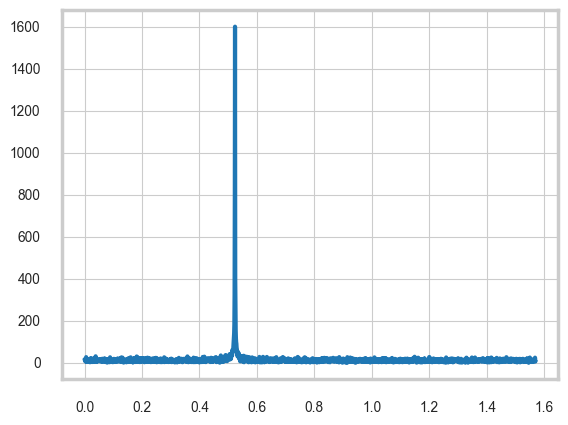

In [8]:
# Set the actual amplitude
theta = np.pi/6

theta1 = np.pi/5
theta2 = -theta1

depths = [i for i in range(2000)]
n_samples = [10 for d in depths]

R = estimate_signal(depths, n_samples, theta)

# R = [0.5*np.exp(1j*theta1*(2*d+1)) + 0.5*np.exp(1j*theta2*(2*d+1)) for d in depths]

fft = np.abs(np.fft.fft(R))

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

In [9]:
# amax = np.argmax(fft[:len(fft)//2])
amax = np.argmax(fft)
print(f'theta: {theta}')
print('peaks:', np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)))

theta: 0.5235987755982988
peaks: 1.0469357518087987 0.523860574986098


In [10]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/4}')
print(f'theta_est: {theta_est}')
print(f'theta: {theta}')
np.sum(np.abs(angle))/8

angles: [-0.12425222+0.21567508j -0.0195024 +0.10343269j]
theta_est: 0.5233657982698127
theta: 0.5235987755982988


0.17708077594057944

$(c_1 + x_1 i s_1, c_2 + x_2 i s_2, c_4 + x_4 i s_4)$

$(c_1 + x_1 i s_1)\cdot (c_2 + x_2 i s_2)$

## Get the real signal values on virtual locations 
One can do this using Chebyshev polynomials with the recurrence $\cos(nx) = 2\cos(x)\cos((n-1)x) - \cos((n-2)x)$

[0.31622777+0.9486833j]
0.30155270333819445


/Users/farrokhlabib/Documents/github/csAE/.venv/lib/python3.10/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: overflow encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


(1.5707963267948966, 0.0, 0.6283185307179586)

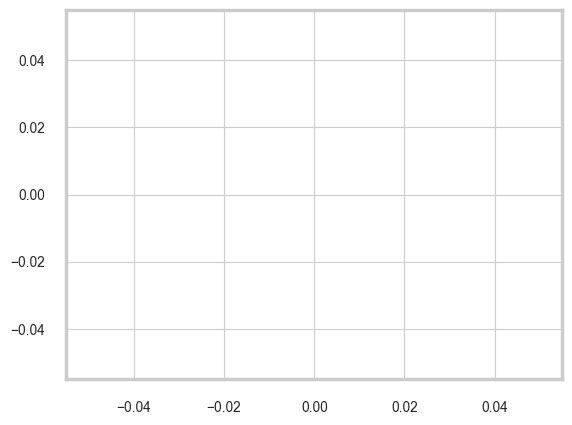

In [11]:
from scipy.special import chebyt, chebyu

def get_cheb_vals(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = chebyt(2*n+1)(np.cos(w))
    return R

def get_cosine_values(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
         R[n] = np.cos((2*n+1)*w)
    return R

# For reproducibility
# np.random.seed(8)

theta = np.pi/5
w = 2*theta

# depths = [0] + [2**i for i in range(6)]
depths = [0]
# n_samples = [(d_max - d)//2 + 1 for d in depths]
n_samples = [400 for _ in depths]

R = estimate_signal(depths, n_samples, theta)
print(R)
S = np.cos(w) + np.random.normal(0.0,1/100)
print(S)
vR = [chebyt(2*n+1)(R[0]) for n in range(500)]
R = vR
# R = get_cheb_vals(d_max, w)
# R = get_cosine_values(d_max, w)

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[1:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)), theta

In [12]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/2}')
print(f'theta_est: {2*theta_est}')
print(f'w: {w}')
np.sum(np.abs(angle))/4

LinAlgError: SVD did not converge

This seems to work: Sample at depth 0 to get an approximation of $T_1(\cos(\omega)) = \cos(\omega)$ and use Chebyshev polynomials to get $T_{2n+1}(\cos(\omega)) = \cos((2n+1)\omega)$ and use ESPRIT or FFT.

Unfortunately, the scaling in this case is no better than classical since $|T_n(\cos(\omega)) - T_n(x)|< n\epsilon$ if $x = \cos(\omega)+\epsilon$ ($x$ being a noisy version of $\cos(\omega)$).

In [ ]:
[2**k + 1 for k in range(1,9)]

[3, 5, 9, 17, 33, 65, 129, 257]

depths:[0, 1, 2, 4, 8, 16, 32]
idx_vals:[1, 3, 5, 9, 17, 33, 65]
{1: 0.30901699437494745, 3: -0.8090169943749475, 5: 1.0, 9: 0.309016994374947, 17: -0.8090169943749469, 33: -0.8090169943749483, 65: 1.0}
64


(0.9326603190344698, 0.6381360077604268, 0.6283185307179586)

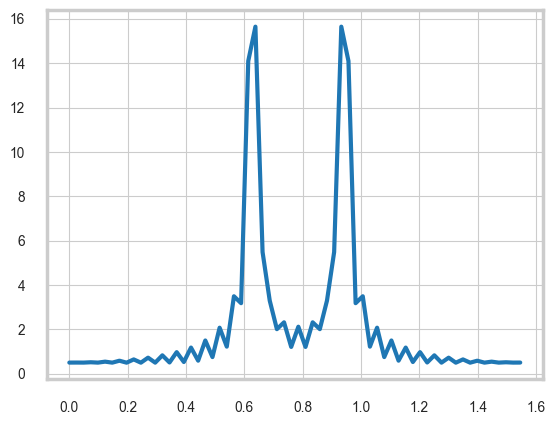

In [ ]:
theta = np.pi/5# np.arccos(a)
w = 2*theta

q=6

depths = [0] + [2**i for i in range(q)]
n_samples = [100 for _ in depths]
print(f'depths:{depths}')

idx = [0]*

S = estimate_signal(depths, n_samples, theta)



fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft)), theta

In [ ]:
R = R[:len(R)//2]
len(R)

256

In [ ]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/4

angles: [ 2.41720381 -2.41720381]
w: 2.0943951023931953
theta_est: 0.9664953736318308
theta:1.0471975511965976


1.2086019063261315

In [ ]:
theta = np.pi/5
w = 2*theta
depths = [d for d in range(4000)]
n_samples = [10 for d in depths]
complex_signal = estimate_signal(depths=depths, n_samples=n_samples, theta=theta)

espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(complex_signal)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')

angles: [-2.51423504 -2.51474992]
w: 1.2566370614359172
theta_est: 0.6285587590036431
theta:0.6283185307179586


We need to solve the sign ambiguity at each depth. Consider the following approach.

Suppose we know $\cos(\omega)$, this implies $\sin(\omega) = \pm \sqrt{1-\cos^2(\omega)}$.

Choose a sign, say $+$. Then we form the exponential $e^{i\omega} = \cos(\omega) + i\sin(\omega)$.

Next we obtain $\cos(3\omega)$ as well and also choose $+$ for the sign, so we have $e^{i3\omega} = \cos(3\omega) + i\sin(3\omega)$.

Then, knowing $\cos(5\omega)$ determines if the chosen signs are consistent.

In [ ]:
w = np.random.random()*np.pi
w

1.2734564911263488

In [ ]:
std = 1/10**4

cos1 = np.cos(w) + np.random.normal(0.0, std)
sin1 = np.sqrt(1-cos1**2)

cos3 = np.cos(3*w) + np.random.normal(0.0, std)
sin3 = np.sqrt(1-cos3**2)

cos5 = np.cos(5*w) + np.random.normal(0.0, std)
sin5 = np.sqrt(1-cos5**2)

print(np.isclose(cos5, np.real((cos1+1.0j*sin1)**2*(cos3-1.0j*sin3)), rtol=0.01))

cos9 = np.cos(9*w) + np.random.normal(0.0, std)

print(np.isclose(cos9, np.real((cos1+1.0j*sin1) * (cos3-1.0j*sin3) * (cos5+1.0j*sin5)), rtol=0.01))

True
True


In [ ]:
q = 3

s = [1] + [2**k+1 for k in range(1, q+1)]
s

[1, 3, 5, 9]

In [ ]:
s[-1] - 2*s[0], s[-2] - s[0] + s[-3]# - s[0] + s[-4] - s[0] + s[-5]# - s[0]# + s[-6] - s[0] + s[-7] - s[0] + s[-8] - s[0] + s[-9]

(3, 3)

In [ ]:
def sign_ambiguity(signal):
    # returns a list of signs at each depth
    signs = [1] #we can choose the first sign freely
    rtol = 0.01
    sines = np.sqrt(1 - signal**2)
    csignal = [signal[0] + signs[0]*1.0j*sines[0]] #first complex signal

    for i in range(1, len(signal) - 1):
        for sign in [-1, 1]:
            cs = signal[i] + sign*1.0j*sines[i]
            cs = cs * csignal[0]**2
            for j in range(i):
                cs = cs*csignal[j]*np.conj(csignal[0])

            if np.isclose(signal[i+1], np.real(cs), rtol=rtol):
                signs.append(sign)
                csignal.append(signal[i] + sign*1.0j*sines[i])
                break

    return signs, csignal

In [ ]:
signal = np.array([np.cos(i*w)+np.random.normal(0.0, std) for i in s])
signal

array([ 0.29296457, -0.77816886,  0.99651255,  0.44893816])

In [ ]:
sign_ambiguity(signal=signal)

([1, -1, 1],
 [(0.29296456924427944+0.9561232980988977j),
  (-0.778168857053688-0.6280551169378026j),
  (0.9965125488285425+0.08344303462387884j)])